In [78]:
import numpy as np
import arepo
import astropy.units as u
import matplotlib.pyplot as plt
from astropy.constants import c
from scipy.spatial import KDTree
from numba import njit

In [79]:
basepath = '/Users/abeane/Projects/GSEgas'

In [80]:
sn = {}
for i in [4, 3, 2]:
    sn_ = arepo.Snapshot(basepath + '/runs/MW3iso_fg0.5/lvl'+str(i)+'/output/', 50, combineFiles=True)
    sn[i] = sn_
    print('loaded lvl', i)

loaded lvl 4
loaded lvl 3
loaded lvl 2


In [81]:
tree = {}
tree4 = {}
for i in [4, 3, 2]:
    tree_ = KDTree(sn[i].part0.pos.value)
    tree[i] = tree_
    
    tree4_ = KDTree(sn[i].part4.pos.value)
    tree4[i] = tree4_

In [83]:
tree_r = {}
tree_key = {}

tree4_r = {}
tree4_key = {}
for i in [4, 3, 2]:
    r_, key_ = tree[i].query(sn[i].part0.pos.value, k=32)
    tree_r[i] = r_
    tree_key[i] = key_
    
    r4_, key4_ = tree4[i].query(sn[i].part4.pos.value, k=32)
    tree4_r[i] = r4_
    tree4_key[i] = key4_
    
    print('queried lvl', i)

queried lvl 4
queried lvl 3
queried lvl 2


In [90]:
key = np.argsort(tree4_r[2][:,16])
for i in range(10):
    print(sn[2].part4.pos.value[key[i]])

[49.9746637  50.02535863 50.00385015]
[49.9747941  50.02550765 50.00395754]
[49.97490644 50.0254593  50.00401668]
[49.98795186 50.02348122 50.00097511]
[49.97500279 50.02559273 50.00412903]
[49.97500727 50.02550416 50.0040154 ]
[49.97492793 50.02560425 50.00429684]
[49.9749034  50.02566607 50.00433557]
[49.97473916 50.02546915 50.00368781]
[49.98806021 50.02305031 50.00076756]


In [26]:
@njit
def find_peaks(rho, key):
    Npart = rho.shape[0]
    is_peak = np.zeros(rho.shape)
    for i in range(Npart):
        if rho[i] == np.max(rho[key[i]]):
            is_peak[i] = 1
    
    return np.where(is_peak)

In [46]:
is_peak = {}
for i in [4, 3, 2]:
    is_peak_ = find_peaks(sn[i].part0.rho.value, tree_key[i])
    is_peak[i] = is_peak_
    print('is_peak lvl', i)

is_peak lvl 4
is_peak lvl 3
is_peak lvl 2


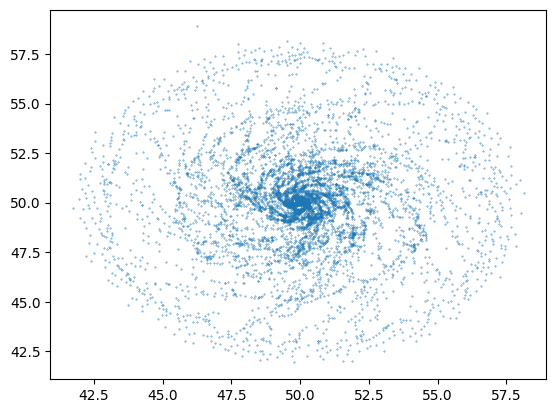

In [34]:
i = 2
plt.scatter(sn[i].part0.pos.value[:,0][is_peak[i]], sn[i].part0.pos.value[:,1][is_peak[i]], s= 0.1)

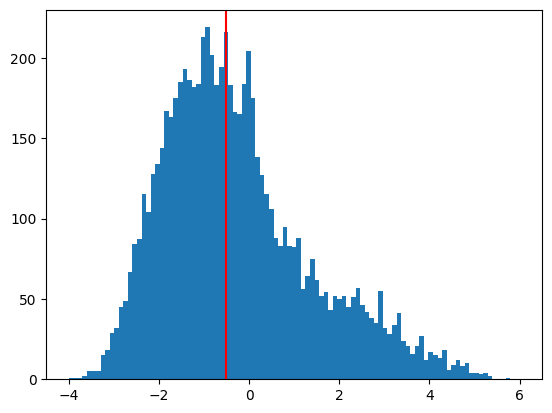

In [42]:
i = 2
plt.hist(np.log10(sn[i].part0.rho.value[is_peak[i]]), bins=np.linspace(-4, 6, 100))
plt.axvline(np.log10(0.301302), c='r')

In [50]:
pos_cloud = {}
for i in [4, 3, 2]:
    key = np.argmin(np.abs(sn[i].part0.rho.value[is_peak[i]] - 1000))
#     print(sn[i].)
    print('lvl', i, sn[i].part0.pos.value[is_peak[i]][key])
    pos_cloud[i] = sn[i].part0.pos.value[is_peak[i]][key]

lvl 4 [51.2306024  48.63672687 50.11367519]
lvl 3 [48.95158578 50.12787953 49.98944608]
lvl 2 [49.62495188 49.14313873 49.99891514]


In [72]:
i = 2
rdiff = np.linalg.norm(sn[i].part0.pos.value - pos_cloud[i], axis=1)
r_in_cloud = rdiff[rdiff < 0.03]
# print(np.where(key)[0])
Nbins = 12

key = np.argsort(r_in_cloud)
key_split = np.array_split(key, Nbins)
    
ave_r = []
ave_rho = []
for j in range(Nbins):
    keyj = key_split[j]
    ave_r.append(np.mean(r_in_cloud[keyj]))
    ave_rho.append(np.mean(sn[i].part0.rho.value[keyj]))


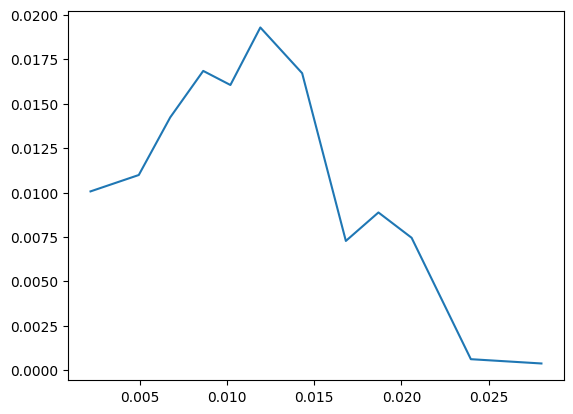

In [73]:
plt.plot(ave_r, ave_rho)

In [77]:
Sigma = np.trapz(ave_rho, ave_r) * 1E10 * u.Msun / u.kpc**2
kappa = 3 * u.cm**2/u.g
tau = kappa * Sigma
tau.to(u.dimensionless_unscaled)

<Quantity 0.00160701>

In [91]:
i = 2
center = np.array([50, 50, 50])
r = np.linalg.norm(sn[i].part0.pos.value - center, axis=1)
# print(np.where(key)[0])
Nbins = 32

key = np.argsort(r)
key_split = np.array_split(key, Nbins)
    
ave_r = []
ave_sfr = []
for j in range(Nbins):
    keyj = key_split[j]
    ave_r.append(np.mean(r[keyj]))
    ave_sfr.append(np.sum(sn[i].part0.sfr.value[keyj]))


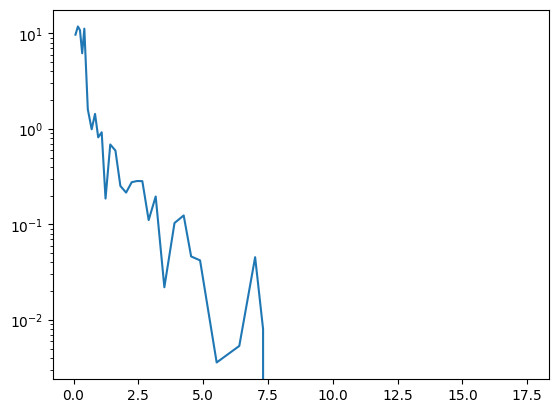

In [94]:
plt.plot(ave_r, ave_sfr)
plt.yscale('log')

In [110]:
i = 2
center = np.array([50, 50, 50])
rdiff = np.linalg.norm(sn[i].part0.pos.value - center, axis=1)
r_in_cloud = rdiff[rdiff < 0.2]
print(len(r_in_cloud))
# print(np.where(key)[0])
Nbins = 64

key = np.argsort(r_in_cloud)
key_split = np.array_split(key, Nbins)
    
ave_r = []
ave_rho = []
for j in range(Nbins):
    keyj = key_split[j]
    ave_r.append(np.mean(r_in_cloud[keyj]))
    ave_rho.append(np.mean(sn[i].part0.rho.value[keyj]))


43078


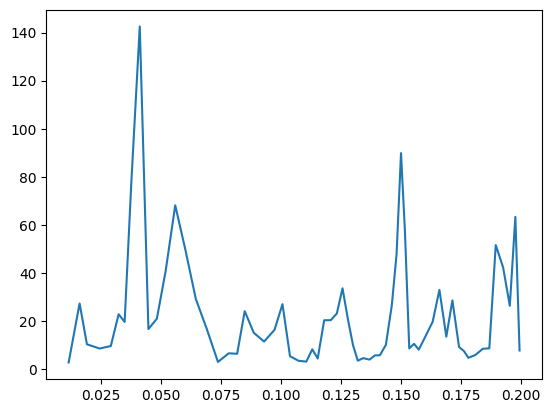

In [111]:
plt.plot(ave_r, ave_rho)

In [116]:
Sigma = 4*np.pi*np.trapz(ave_rho, ave_r) * 1E10 * u.Msun / u.kpc**2 * 0.0127
kappa = 10 * u.cm**2/u.g
tau = kappa * Sigma
tau.to(u.dimensionless_unscaled)

<Quantity 14.38871456>

In [114]:
np.max(sn[2].part4.RadFeedTau)

0.0

In [124]:
i = 2
Rcut = 0.5
center = np.array([50, 50, 50])
posdiff = sn[i].part0.pos.value - center
R = np.linalg.norm(posdiff[:,:2], axis=1)
mass_in_R = np.sum(sn[i].part0.mass.value[R < Rcut])
sigma = mass_in_R / (np.pi*Rcut**2)
sigma *= 0.0127 * 1E10 * u.Msun/u.kpc**2
print(sigma.to(u.g/u.cm**2))
kappa = 10 * u.cm**2/u.g
tau = kappa*sigma
print(tau.to(u.dimensionless_unscaled))

0.0034197806077720647 g / cm2
0.03419780607772065
